# Improved Bollinger Band Trading Bot 

Build a Bollinger Band trading algorithm, introduce concepts to readers such as Transaction costs, stop losses and order sizing.

In [27]:
# need this version of Matplotlib due to bug in Backtrader
!pip install matplotlib==3.2.2

# Import libraries & initialise notebook

In [41]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os

from alpha_vantage.foreignexchange import ForeignExchange
import warnings

In [42]:
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
# I add the line below to let the plots take advantage of my Macbook Retina screen, feel free to remove
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

## Gather FX Historical Data
I will use Alpha vantage to gather historical data, in order for you to collect data yourself, you'll need to create an free account. visit the website
https://www.alphavantage.co/ and follow the instructions there. <br>
<br>
It's never a good practice to copy your credentials as free text into your code.
I've placed my credentials in a .env file which stays with me locally.

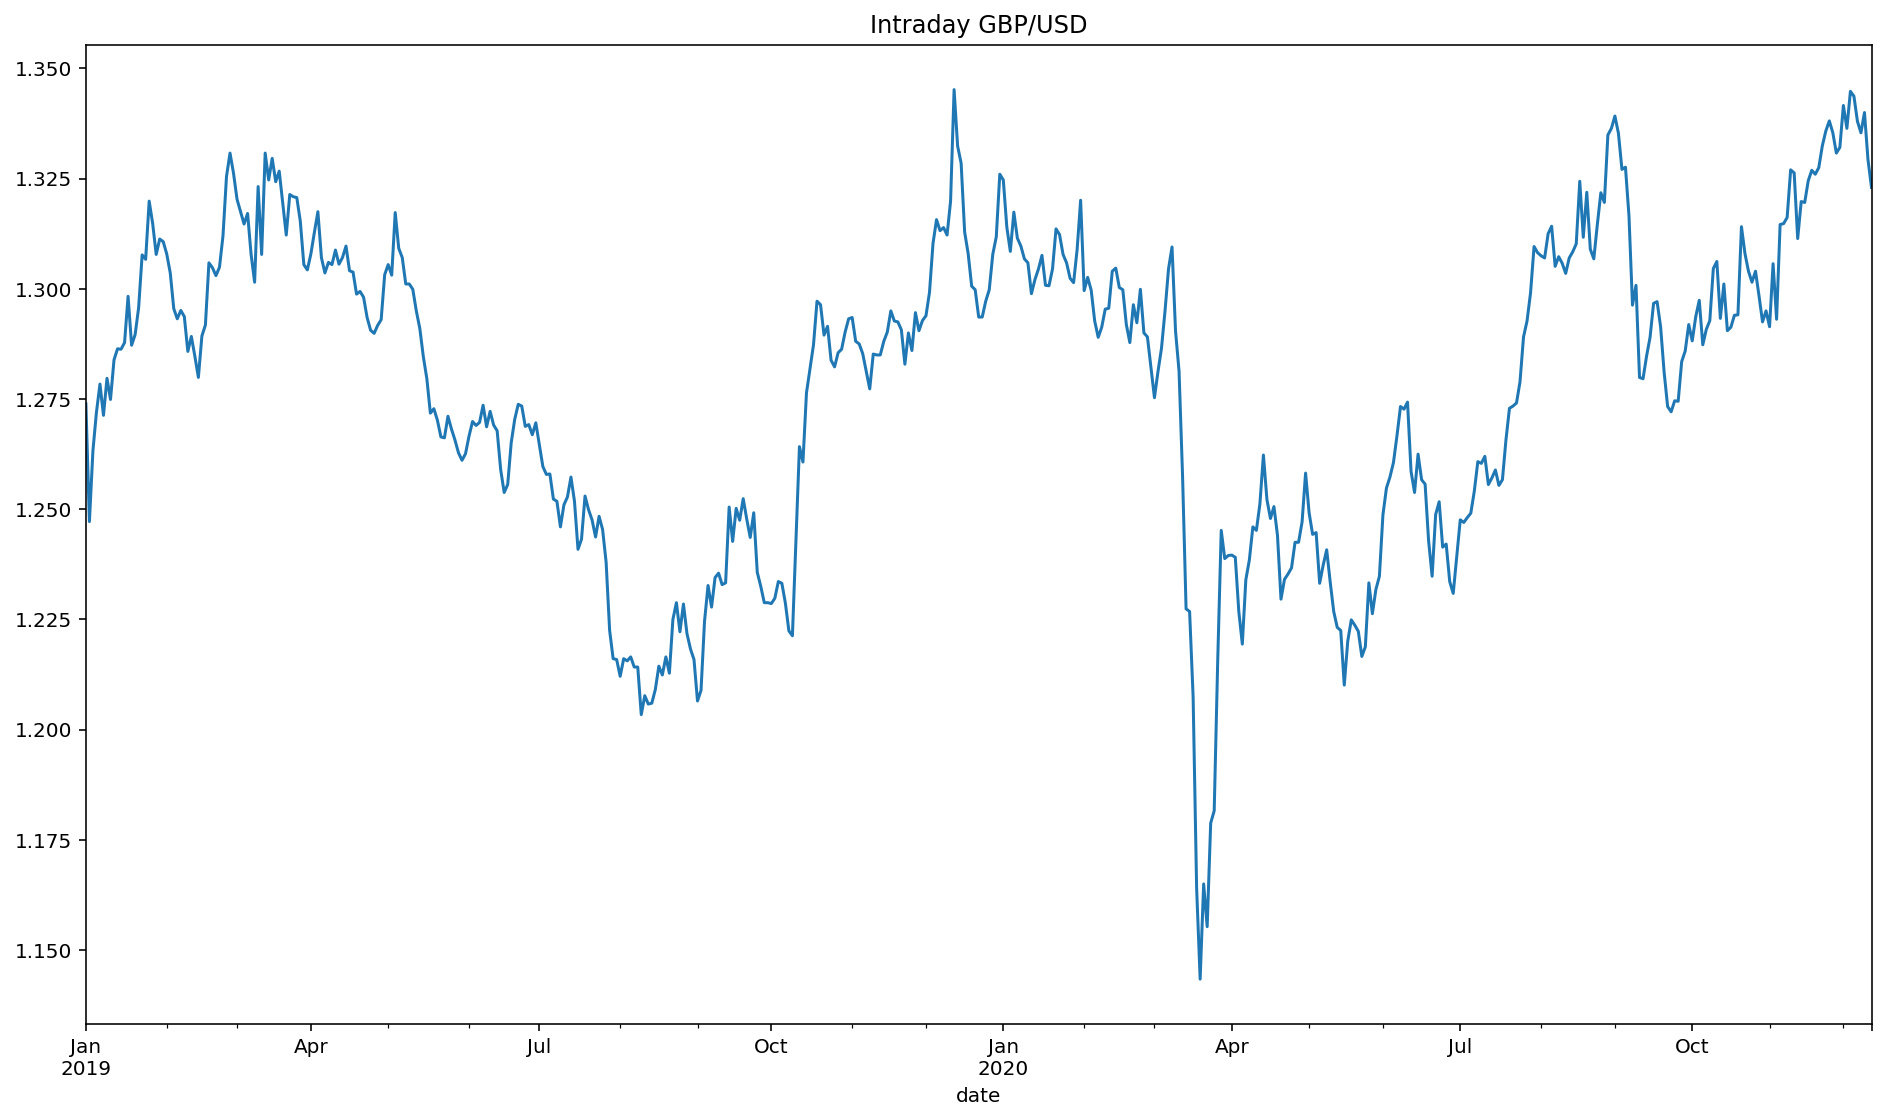

In [43]:
cc = ForeignExchange(key=os.environ['alpha_vantage_token'],output_format='pandas')

# We will retreive daily OHLC prices, Alpha vantage also contains intraday results which are difficult to come by elsewhere

data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',to_symbol='USD', outputsize='full')

# Let's just look at 2015 onwards 

data_df.sort_index(inplace=True)
data_df = data_df.loc['2019-01-01':]

# Plot the results to ensure everything worked

data_df['4. close'].plot()
plt.title('Intraday GBP/USD')
plt.show()

In [44]:
# Rename & rearrange the fields so they can be ingested by Backtrader
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns = ['High', 'Low', 'Open', 'Close']

# Algorithm Strategy Definition 
To do the backtesting, we will use the Backtrader Python package https://www.backtrader.com/. It's a bigger learning curve to compared to other platforms such as Quantopian, but I really enjoy the added flexibility and the fact you can easily integrate with other Python packages/platforms.

In [204]:
class grid_bander_bands(bt.Strategy):
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
        
    def notify_trade(self, trade):
        if trade.justopened:
            print('----TRADE OPENED----')
            print('Size: {}, Price: {}, Value: {}, ref: {}'.format(trade.size, trade.price, trade.value, trade.ref))
            print('-' * 25)
        elif trade.isclosed:
            print('----TRADE CLOSED----')
            print('Profit, Gross {}, Net {}, Price {}, Ref: {}'.format(
                trade.pnl,
                trade.pnlcomm,
                trade.price,
                trade.ref))
            print('-' * 25)
        else:
            return
         
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('ORDER ACCEPTED/SUBMITTED')
            self.order = order
            self.buyprice = order.executed.price
            self.buycomm = order.executed.comm
            return
        

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log("BUY EXECUTED, %f, MARGIN REMAINING: %f" % (order.executed.price, cerebro.broker.get_cash()))
            elif order.issell():
                self.log("SELL EXECUTED, %f. BALANCE: %f. MARGIN REMAINING: %f." %
                         (order.executed.price,
                          cerebro.broker.getvalue(),
                          cerebro.broker.get_cash()
                          ))

        if not order.alive():
            self.order = None  # indicate no order is pending 
  
    
    def __init__(self):
        
        # Sentinel to None: new orders allowed
        self.order = None
        
        self.mom_sig = self.data.close > self.data.close(-1)
        bt.LinePlotterIndicator(self.mom_sig, name='momentum_sig')
        
        self.rev_sig = self.data.close < self.data.close(-1)
        bt.LinePlotterIndicator(self.rev_sig, name='reversal_sig')
        
        
    
    def next(self):
        
        if self.order:
            # An order is pending ... nothing can be done
            return
        
        # Check we are not in the market
        if not self.position:
                self.order = self.buy_bracket(price=1.2, limitprice=1.3, stopprice=1.1, size=4000)
        

## Run the strategy over the last 2 years 

In [205]:
%%time
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(grid_bander_bands)
# Add a FixedSize sizer according to the stake
#cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
results = cerebro.run()

2019-01-04, ORDER ACCEPTED/SUBMITTED
2019-01-04, ORDER ACCEPTED/SUBMITTED
2019-01-04, ORDER ACCEPTED/SUBMITTED
2019-01-04, ORDER ACCEPTED/SUBMITTED
2019-01-04, ORDER ACCEPTED/SUBMITTED
2019-01-04, ORDER ACCEPTED/SUBMITTED
2019-09-03, BUY EXECUTED, 1.200000, MARGIN REMAINING: 5200.000000
----TRADE OPENED----
Size: 4000, Price: 1.2, Value: 4800.0, ref: 334
-------------------------
2019-10-21, SELL EXECUTED, 1.300000. BALANCE: 10400.000000. MARGIN REMAINING: 10400.000000.
----TRADE CLOSED----
Profit, Gross 400.00000000000034, Net 400.00000000000034, Price 1.2, Ref: 334
-------------------------
2019-10-22, ORDER ACCEPTED/SUBMITTED
2019-10-22, ORDER ACCEPTED/SUBMITTED
2019-10-22, ORDER ACCEPTED/SUBMITTED
2019-10-22, ORDER ACCEPTED/SUBMITTED
2019-10-22, ORDER ACCEPTED/SUBMITTED
2019-10-22, ORDER ACCEPTED/SUBMITTED
2020-03-18, BUY EXECUTED, 1.200000, MARGIN REMAINING: 5600.000000
----TRADE OPENED----
Size: 4000, Price: 1.2, Value: 4800.0, ref: 335
-------------------------
2020-07-29, SELL 

Sharpe: 51.000
Norm. Annual Return: 3.88%
Max Drawdown: 2.18%


<IPython.core.display.Javascript object>

[[<Figure size 1152x648 with 6 Axes>]]

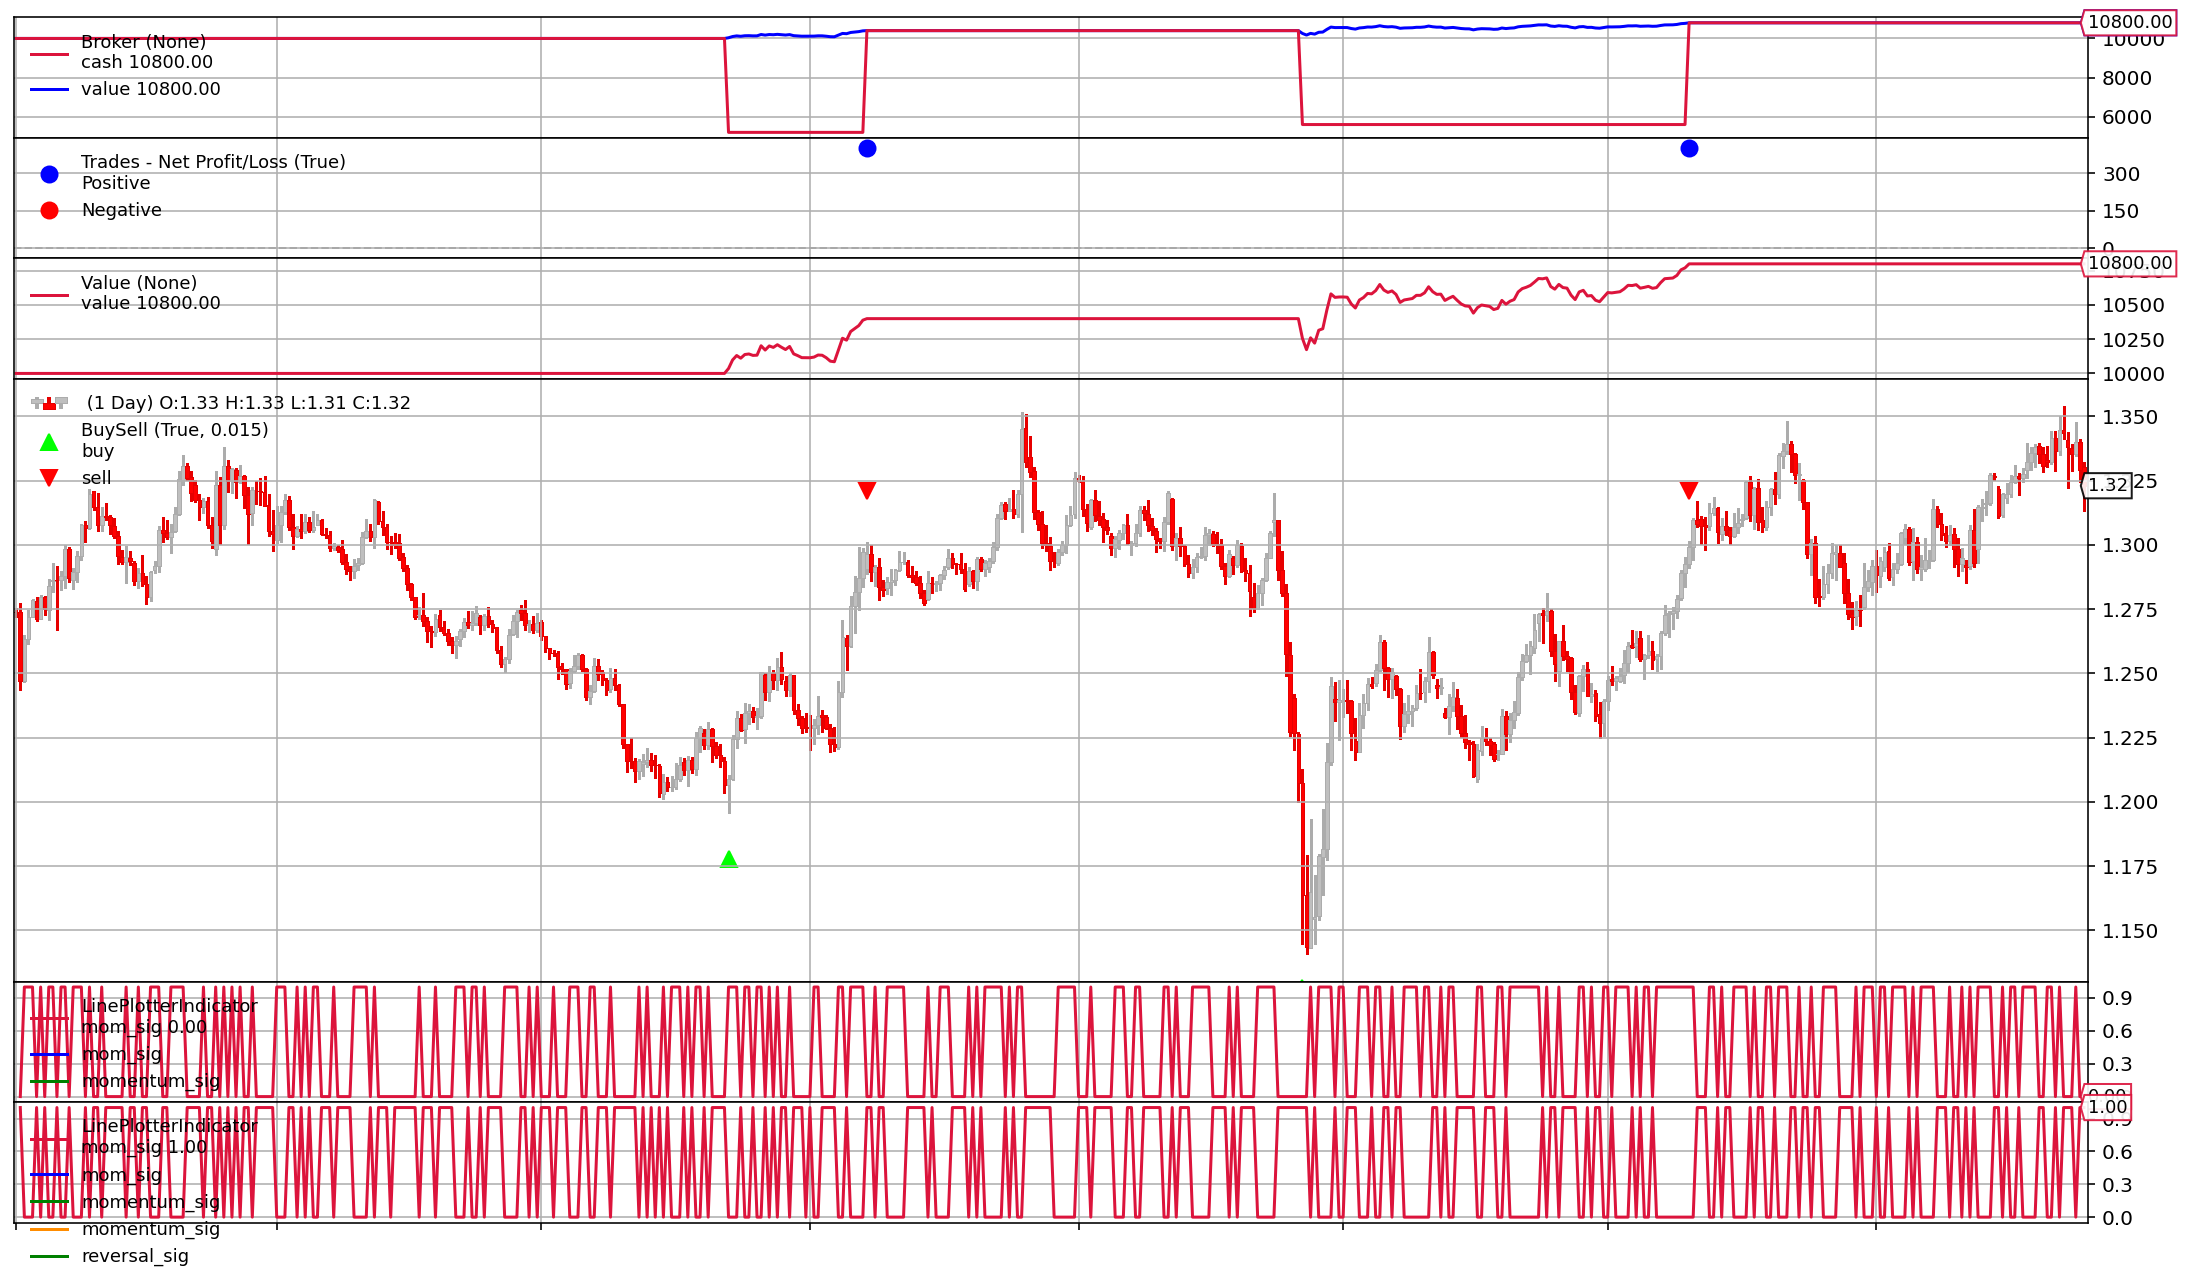

In [206]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot(iplot=True, volume=False, width=45, style='candle')